In [1]:
import tensorflow as tf
print(tf.__version__)

2.17.1


In [2]:
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

GPU Available:  []


## Task:

Download the following dataset

**Dataset link**: [https://www.kaggle.com/datasets/paramaggarwal/fashion-product-](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset) [images-dataset](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset)

Using the dataset carry out the following tasks:-

1. Detailed EDA
2. Given an image, input build a deep learning based model that can predict the following outputs:-
    1. Color of product
    2. Type of product (T-shirt, shoes, etc.)
    3. Preferable season to use this product
    4. Gender (Men, Women, Unisex)
3. Once you build the model, take a few sample screenshots of fashion products from the Amazon website and use your model to predict the result.

## Bonus points

1. If you can create an API script for serving the model
2. Create Streamlit or any other GUI-based application for demonstration

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
styles = pd.read_csv("/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv", on_bad_lines='skip')

# EDA

In [5]:
styles.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [6]:
target_column_name = ["baseColour", "articleType", "season", "gender"]

In [7]:
styles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44424 non-null  int64  
 1   gender              44424 non-null  object 
 2   masterCategory      44424 non-null  object 
 3   subCategory         44424 non-null  object 
 4   articleType         44424 non-null  object 
 5   baseColour          44409 non-null  object 
 6   season              44403 non-null  object 
 7   year                44423 non-null  float64
 8   usage               44107 non-null  object 
 9   productDisplayName  44417 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.4+ MB


- Columns: 9
- Rows: 44424
- Missing Values: 5 Columns
  - baseColour
  - season
  - year
  - usage
  - ProductDisplayName
- Wrong year dtype 


# Preliminary Analysis

In [8]:
styles.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [9]:
styles.dtypes

id                      int64
gender                 object
masterCategory         object
subCategory            object
articleType            object
baseColour             object
season                 object
year                  float64
usage                  object
productDisplayName     object
dtype: object

In [10]:
styles['year'].iloc[0] # Float -> Time.year

2011.0

# Check for Duplicate

In [11]:
(
    styles
    [styles.duplicated(keep=False)]
    
)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName


# Detailed Analysis

In [12]:
print(styles.columns)

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName'],
      dtype='object')


# gender

### **Note**:
- assuming point D. Gender (Men, Women, Unisex)
    - Boys -> Men
    - Girls -> Women
- imbalance in classes
    - Unisex have less labels 


In [13]:
styles.gender.value_counts()

gender
Men       22147
Women     18631
Unisex     2161
Boys        830
Girls       655
Name: count, dtype: int64

In [14]:
styles.gender.value_counts(normalize=True)

gender
Men       0.498537
Women     0.419390
Unisex    0.048645
Boys      0.018684
Girls     0.014744
Name: proportion, dtype: float64

# articleType


### Note:
- imbalance data
- Lots of classes (posible solution) :
  - merge cat into one base on Domain Knowledge
  - Could set a minimum count threshold (e.g., keep only classes with at least 100 or 500 samples) and group the rest into an "Other" category.
  - Use class weights 

In [15]:
styles.articleType.nunique()

143

In [16]:
styles.articleType.unique()

array(['Shirts', 'Jeans', 'Watches', 'Track Pants', 'Tshirts', 'Socks',
       'Casual Shoes', 'Belts', 'Flip Flops', 'Handbags', 'Tops', 'Bra',
       'Sandals', 'Shoe Accessories', 'Sweatshirts', 'Deodorant',
       'Formal Shoes', 'Bracelet', 'Lipstick', 'Flats', 'Kurtas',
       'Waistcoat', 'Sports Shoes', 'Shorts', 'Briefs', 'Sarees',
       'Perfume and Body Mist', 'Heels', 'Sunglasses', 'Innerwear Vests',
       'Pendant', 'Nail Polish', 'Laptop Bag', 'Scarves', 'Rain Jacket',
       'Dresses', 'Night suits', 'Skirts', 'Wallets', 'Blazers', 'Ring',
       'Kurta Sets', 'Clutches', 'Shrug', 'Backpacks', 'Caps', 'Trousers',
       'Earrings', 'Camisoles', 'Boxers', 'Jewellery Set', 'Dupatta',
       'Capris', 'Lip Gloss', 'Bath Robe', 'Mufflers', 'Tunics',
       'Jackets', 'Trunk', 'Lounge Pants', 'Face Wash and Cleanser',
       'Necklace and Chains', 'Duffel Bag', 'Sports Sandals',
       'Foundation and Primer', 'Sweaters', 'Free Gifts', 'Trolley Bag',
       'Tracksuits', 'S

In [17]:
styles.articleType.value_counts().values 

array([7067, 3217, 2845, 2542, 2036, 1844, 1762, 1759, 1323, 1073,  936,
        914,  897,  849,  813,  724,  686,  637,  613,  609,  547,  530,
        500,  477,  464,  427,  416,  347,  329,  315,  304,  290,  285,
        283,  277,  263,  258,  242,  234,  229,  189,  177,  176,  175,
        160,  144,  141,  140,  128,  119,  118,  116,  106,  102,   97,
         94,   91,   90,   88,   85,   82,   76,   67,   66,   61,   61,
         58,   57,   53,   52,   49,   48,   47,   44,   42,   40,   39,
         38,   38,   34,   34,   32,   32,   30,   29,   28,   25,   23,
         20,   20,   19,   18,   17,   17,   16,   16,   16,   16,   15,
         13,   13,   12,   12,   12,   11,   11,   11,    9,    9,    8,
          8,    8,    7,    7,    7,    6,    6,    6,    6,    6,    5,
          5,    5,    4,    4,    4,    4,    4,    3,    3,    3,    3,
          2,    2,    2,    2,    1,    1,    1,    1,    1,    1,    1])

In [18]:
(styles.articleType.value_counts() < 2).sum(), (styles.articleType.value_counts() >= 500).sum()

(7, 23)

In [ ]:
sorted_articles = styles['articleType'].value_counts().index.tolist()
sns.catplot(x='articleType', kind='count', data=styles, height=8, aspect=18/8, order=sorted_articles) 
plt.xlabel("articleType") 
plt.ylabel("Count") 
plt.xticks(rotation=90)
plt.plot()

[]

In [20]:
# threshold of 500
threshold = 500
article_counts = styles['articleType'].value_counts()
major_categories = article_counts[article_counts >= threshold].index.tolist()


styles['articleType'].apply(
    lambda x: x if x in major_categories else 'Other'
).value_counts()

articleType
Other                    9701
Tshirts                  7067
Shirts                   3217
Casual Shoes             2845
Watches                  2542
Sports Shoes             2036
Kurtas                   1844
Tops                     1762
Handbags                 1759
Heels                    1323
Sunglasses               1073
Wallets                   936
Flip Flops                914
Sandals                   897
Briefs                    849
Belts                     813
Backpacks                 724
Socks                     686
Formal Shoes              637
Perfume and Body Mist     613
Jeans                     609
Shorts                    547
Trousers                  530
Flats                     500
Name: count, dtype: int64

In [21]:
# threshold of 1%
threshold = 1.0 # grater than 1 %
article_counts = styles['articleType'].value_counts(normalize=True) * 100
major_categories = article_counts[article_counts >= threshold].index.tolist()


styles['articleType'].apply(
    lambda x: x if x in major_categories else 'Other'
).value_counts()

articleType
Other                    8760
Tshirts                  7067
Shirts                   3217
Casual Shoes             2845
Watches                  2542
Sports Shoes             2036
Kurtas                   1844
Tops                     1762
Handbags                 1759
Heels                    1323
Sunglasses               1073
Wallets                   936
Flip Flops                914
Sandals                   897
Briefs                    849
Belts                     813
Backpacks                 724
Socks                     686
Formal Shoes              637
Perfume and Body Mist     613
Jeans                     609
Shorts                    547
Trousers                  530
Flats                     500
Bra                       477
Dresses                   464
Name: count, dtype: int64

# season

### Note:
- Imbalance 

In [22]:
styles.season.value_counts()

season
Summer    21472
Fall      11431
Winter     8517
Spring     2983
Name: count, dtype: int64

In [23]:
styles.season.value_counts(normalize=True) * 100 # Imbalance data 

season
Summer    48.357093
Fall      25.743756
Winter    19.181136
Spring     6.718015
Name: proportion, dtype: float64

# baseColour
### Note:
- Imbalace classes
- could merge similar colors into broader color families
- Keep top N colors

In [24]:
styles.baseColour.value_counts()

baseColour
Black                9728
White                5538
Blue                 4918
Brown                3494
Grey                 2741
Red                  2455
Green                2115
Pink                 1860
Navy Blue            1789
Purple               1640
Silver               1090
Yellow                778
Beige                 749
Gold                  628
Maroon                581
Orange                530
Olive                 410
Multi                 394
Cream                 390
Steel                 315
Charcoal              228
Peach                 195
Off White             182
Skin                  179
Lavender              162
Grey Melange          146
Khaki                 139
Magenta               129
Teal                  120
Tan                   114
Mustard                97
Bronze                 95
Copper                 86
Turquoise Blue         69
Rust                   66
Burgundy               45
Metallic               43
Coffee Brown           31
M

In [25]:
# Define color families
color_families = {
    'Black/Grey': ['Black', 'Grey', 'Charcoal', 'Grey Melange'],
    'White/Cream': ['White', 'Off White', 'Cream'],
    'Blue': ['Blue', 'Navy Blue', 'Teal', 'Turquoise Blue', 'Sea Green'],
    'Brown/Beige': ['Brown', 'Beige', 'Tan', 'Coffee Brown', 'Mushroom Brown', 'Taupe'],
    'Red/Pink': ['Red', 'Pink', 'Rose', 'Maroon', 'Burgundy'],
    'Green': ['Green', 'Olive', 'Lime Green', 'Fluorescent Green'],
    'Yellow/Orange': ['Yellow', 'Orange', 'Mustard'],
    'Purple/Lavender': ['Purple', 'Lavender', 'Magenta', 'Mauve'],
    'Metallic': ['Silver', 'Gold', 'Bronze', 'Copper', 'Metallic', 'Steel'],
    'Other': ['Multi', 'Skin', 'Khaki', 'Rust', 'Nude', 'Peach']
}

# Create a mapping from individual color to color family
color_to_family = {}
for family, colors in color_families.items():
    for color in colors:
        color_to_family[color] = family

# Apply mapping to create new target variable
styles['baseColour'].map(color_to_family).value_counts()

baseColour
Black/Grey         12843
Blue                6918
White/Cream         6110
Red/Pink            4969
Brown/Beige         4415
Green               2536
Metallic            2257
Purple/Lavender     1960
Yellow/Orange       1405
Other                996
Name: count, dtype: int64

# DF

In [26]:
def final_df(df):

    return (
        df
        .dropna(axis=0)
        .assign(
            gender=lambda df_: (
                df_
                .gender
                .replace({"Girls": "Women", "Boys": "Men"})
            )
        )
        .assign(
            articleType=lambda df_: (
                df_
                .articleType
                .apply(lambda x: x if x in major_categories else 'Other')
                
            )
        )
        .assign(
            baseColour=lambda df_: (
                df_
                .baseColour
                .map(color_to_family)
            )
        )
        
        
    )

In [27]:
final_df(styles[target_column_name])["baseColour"].value_counts()


baseColour
Black/Grey         12834
Blue                6913
White/Cream         6109
Red/Pink            4968
Brown/Beige         4414
Green               2535
Metallic            2257
Purple/Lavender     1958
Yellow/Orange       1404
Other                996
Name: count, dtype: int64

In [28]:
target_column_name.append("id")
styles = final_df(styles[target_column_name])
styles.to_csv('targets.csv', index=False)

In [29]:
from IPython.display import FileLink
FileLink('targets.csv')

/kaggle/working/targets.csv

In [30]:
import pandas as pd
images_csv = pd.read_csv("/kaggle/input/fashion-product-images-dataset/fashion-dataset/images.csv")

In [31]:
images_csv.head()

,filename,link
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...
2,59263.jpg,http://assets.myntassets.com/v1/images/style/p...
3,21379.jpg,http://assets.myntassets.com/v1/images/style/p...
4,53759.jpg,http://assets.myntassets.com/v1/images/style/p...


In [32]:
ui = images_csv.set_index(images_csv["filename"].str.split(".").str[0].values)
ui = ui.set_index(ui.index.astype(int))
images_final = ui.loc[styles.id.values]
images_final.to_csv("images.csv", index=False)

In [33]:
FileLink('images.csv')

/kaggle/working/images.csv

In [34]:
images_final = images_final[images_final['link'] != "undefined"]

In [35]:
images_final.head(1), styles.head(1)

(        filename                                               link
 15970  15970.jpg  http://assets.myntassets.com/v1/images/style/p...,
   baseColour articleType season gender     id
 0       Blue      Shirts   Fall    Men  15970)

In [36]:
images_style_df = styles.merge(images_final.reset_index(), left_on="id", right_on="index").drop(columns=["link", "index", "id"]).set_index("filename")
images_style_df.head()

,baseColour,articleType,season,gender
filename,,,,
15970.jpg,Blue,Shirts,Fall,Men
39386.jpg,Blue,Jeans,Summer,Men
59263.jpg,Metallic,Watches,Winter,Women
21379.jpg,Black/Grey,Other,Fall,Men
53759.jpg,Black/Grey,Tshirts,Summer,Men


In [37]:
styles.shape, images_final.shape, images_style_df.shape

((44388, 5), (44383, 2), (44383, 4))

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer

In [39]:
train_df, test_df = train_test_split(images_style_df, test_size=0.1, stratify=images_style_df[['season', "gender"]])
train_df, val_df = train_test_split(train_df, test_size=0.1)

In [40]:
len(train_df), len(val_df), len(test_df)

(35949, 3995, 4439)

In [41]:
from sklearn.base import TransformerMixin, BaseEstimator
class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    """
    A wrapper for using LabelEncoder with ColumnTransformer to transform all columns.
    LabelEncoder is not directly compatible with ColumnTransformer.
    """
    def __init__(self):
        self.encoders = {}
        
    def fit(self, X, y=None):
        # Create an encoder for each column
        for col in X.columns:
            self.encoders[col] = LabelEncoder().fit(X[col].astype(str))
        return self
        
    def transform(self, X):
        # Apply transformation to each column
        X_transformed = X.copy()
        for col in X.columns:
            if col in self.encoders:
                X_transformed[col] = self.encoders[col].transform(X[col].astype(str))
        return X_transformed

    def get_label_encoder(self):
        return self.encoders

In [42]:
encoder = MultiColumnLabelEncoder()

# Fit and transform the data
train_df_encoded = encoder.fit_transform(train_df)
test_df_encoded = encoder.transform(test_df)
val_df_encoded = encoder.transform(val_df)

In [50]:
import pickle 

encoders_dict = encoder.get_label_encoder()

with open('saved_encoders_dictionary.pkl', 'wb') as f:
    pickle.dump(encoders_dict, f)
        
with open('saved_encoders_dictionary.pkl', 'rb') as f:
    loaded_encoders_dict = pickle.load(f)

In [51]:
loaded_encoders_dict

{'baseColour': LabelEncoder(),
 'articleType': LabelEncoder(),
 'season': LabelEncoder(),
 'gender': LabelEncoder()}

In [49]:
loaded_encoders_dict["gender"].inverse_transform([2])

array(['Women'], dtype=object)

In [52]:
FileLink("saved_encoders_dictionary.pkl")

/kaggle/working/saved_encoders_dictionary.pkl

In [44]:
train_df_encoded.to_csv("train_df_encoded.csv")
val_df_encoded.to_csv("val_df_encoded.csv")
test_df_encoded.to_csv("test_df_encoded.csv")
FileLink("train_df_encoded.csv")

FileLink("test_df_encoded.csv")

/kaggle/working/test_df_encoded.csv

In [45]:
FileLink("val_df_encoded.csv")

/kaggle/working/val_df_encoded.csv

In [45]:
target_columns = ['baseColour', 'articleType', 'season', 'gender']  # Target features

# Get the class counts for each target column
class_counts = {col: train_df_encoded[col].value_counts() for col in target_columns}

# Find the lowest available class count across all target features
min_samples = min(min(counts) for counts in class_counts.values())

print("Minimum class count for balancing:", min_samples)


Minimum class count for balancing: 383


In [46]:
train_df_encoded

,baseColour,articleType,season,gender
filename,,,,
42173.jpg,0,23,3,0
29313.jpg,0,0,2,1
41859.jpg,0,15,2,0
23536.jpg,7,14,1,0
38334.jpg,8,21,2,2
...,...,...,...,...
53814.jpg,1,13,0,2
19299.jpg,4,25,3,2
21991.jpg,2,9,3,2


In [47]:
train_df

,baseColour,articleType,season,gender
filename,,,,
42173.jpg,Black/Grey,Tshirts,Winter,Men
29313.jpg,Black/Grey,Backpacks,Summer,Unisex
41859.jpg,Black/Grey,Sandals,Summer,Men
23536.jpg,Red/Pink,Perfume and Body Mist,Spring,Men
38334.jpg,White/Cream,Tops,Summer,Women
...,...,...,...,...
53814.jpg,Blue,Other,Fall,Women
19299.jpg,Metallic,Watches,Winter,Women
21991.jpg,Brown/Beige,Handbags,Winter,Women


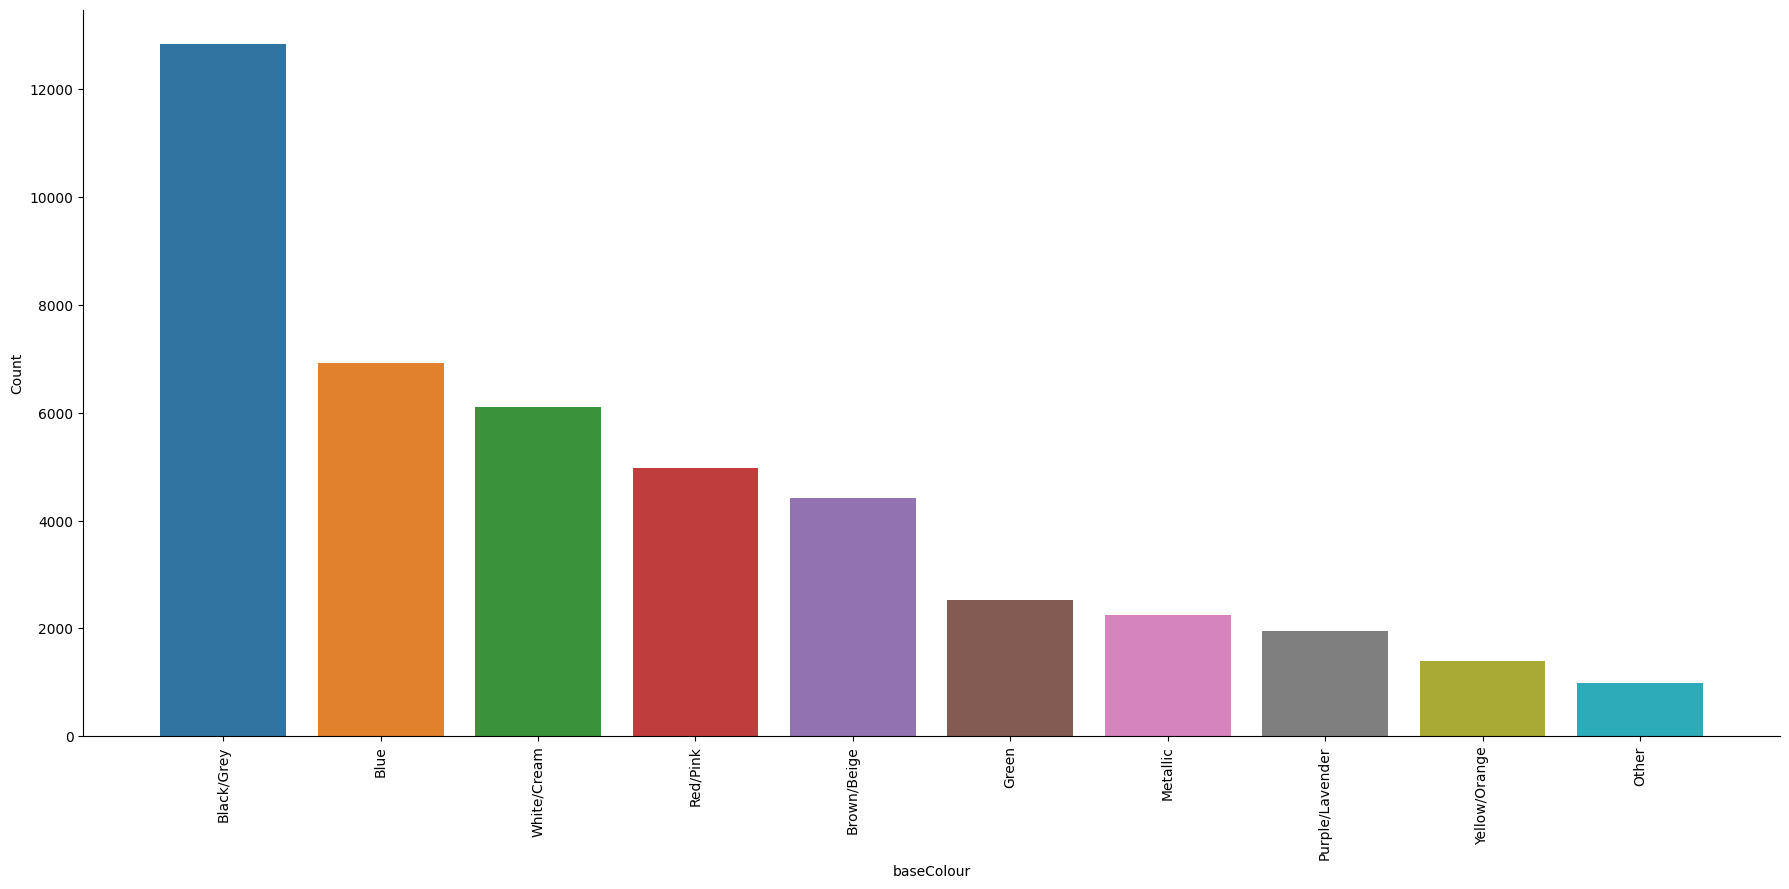

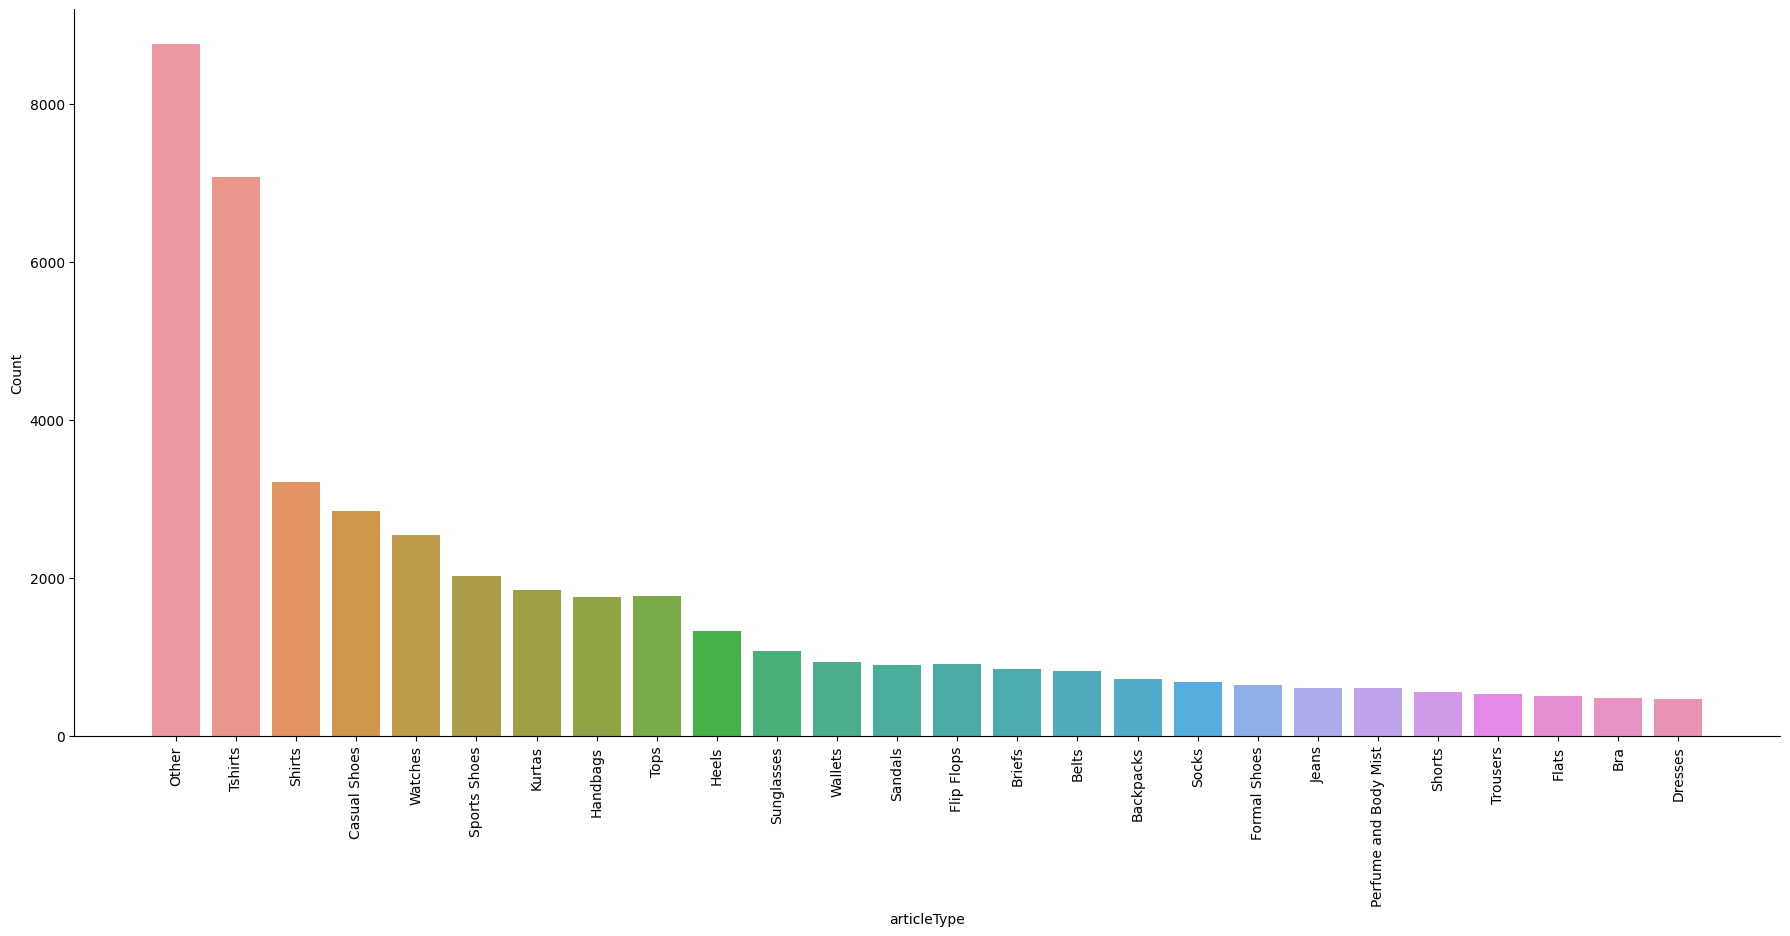

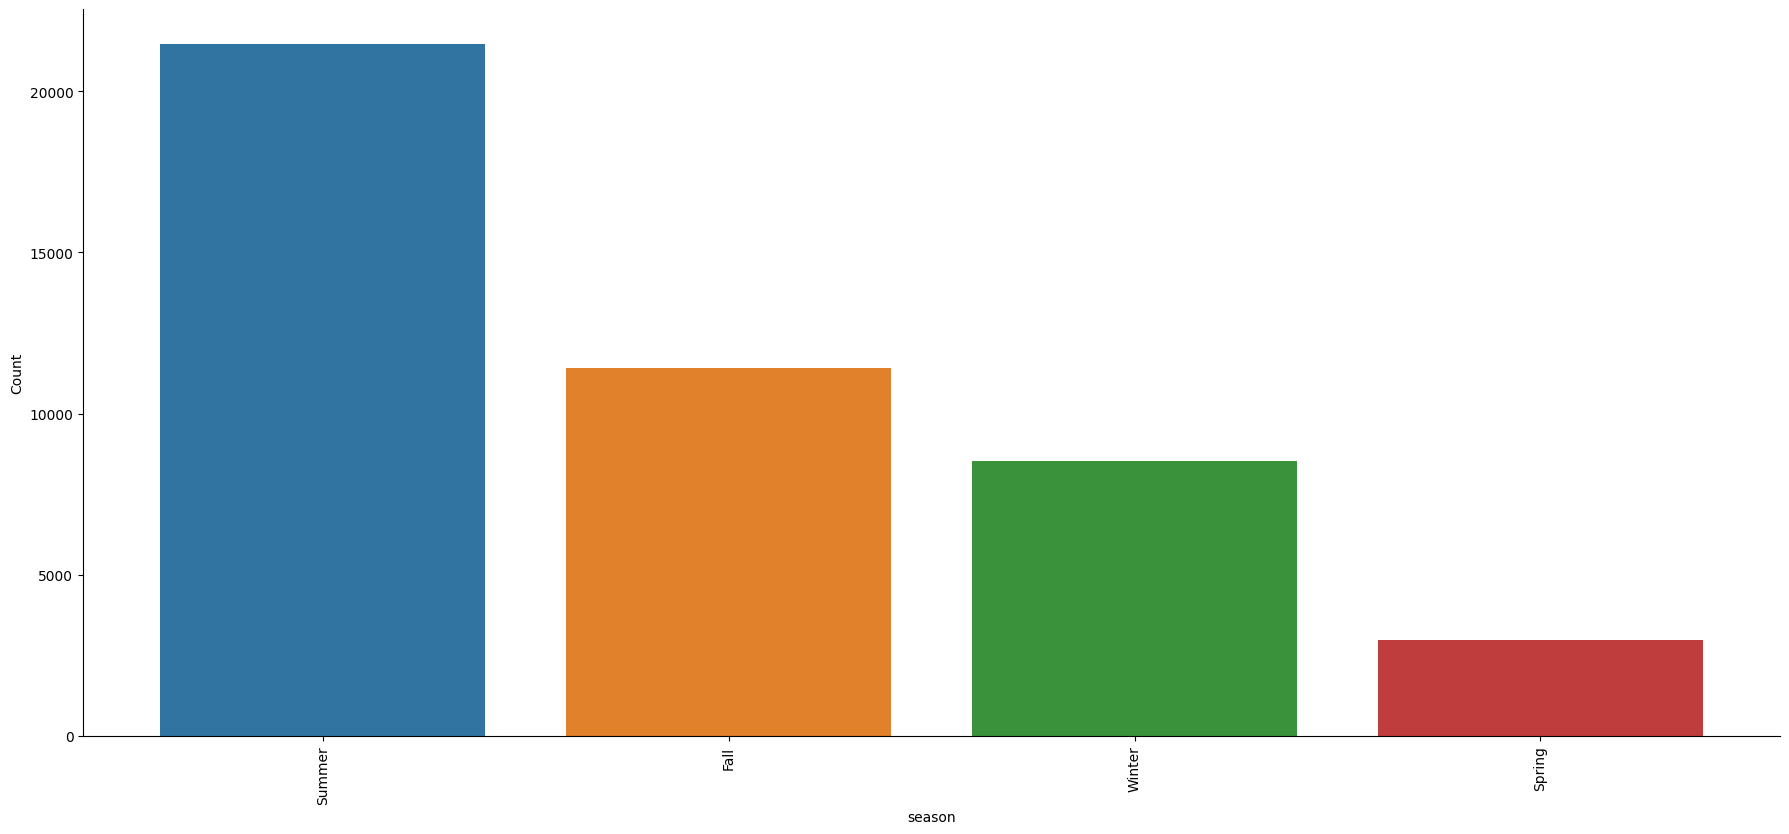

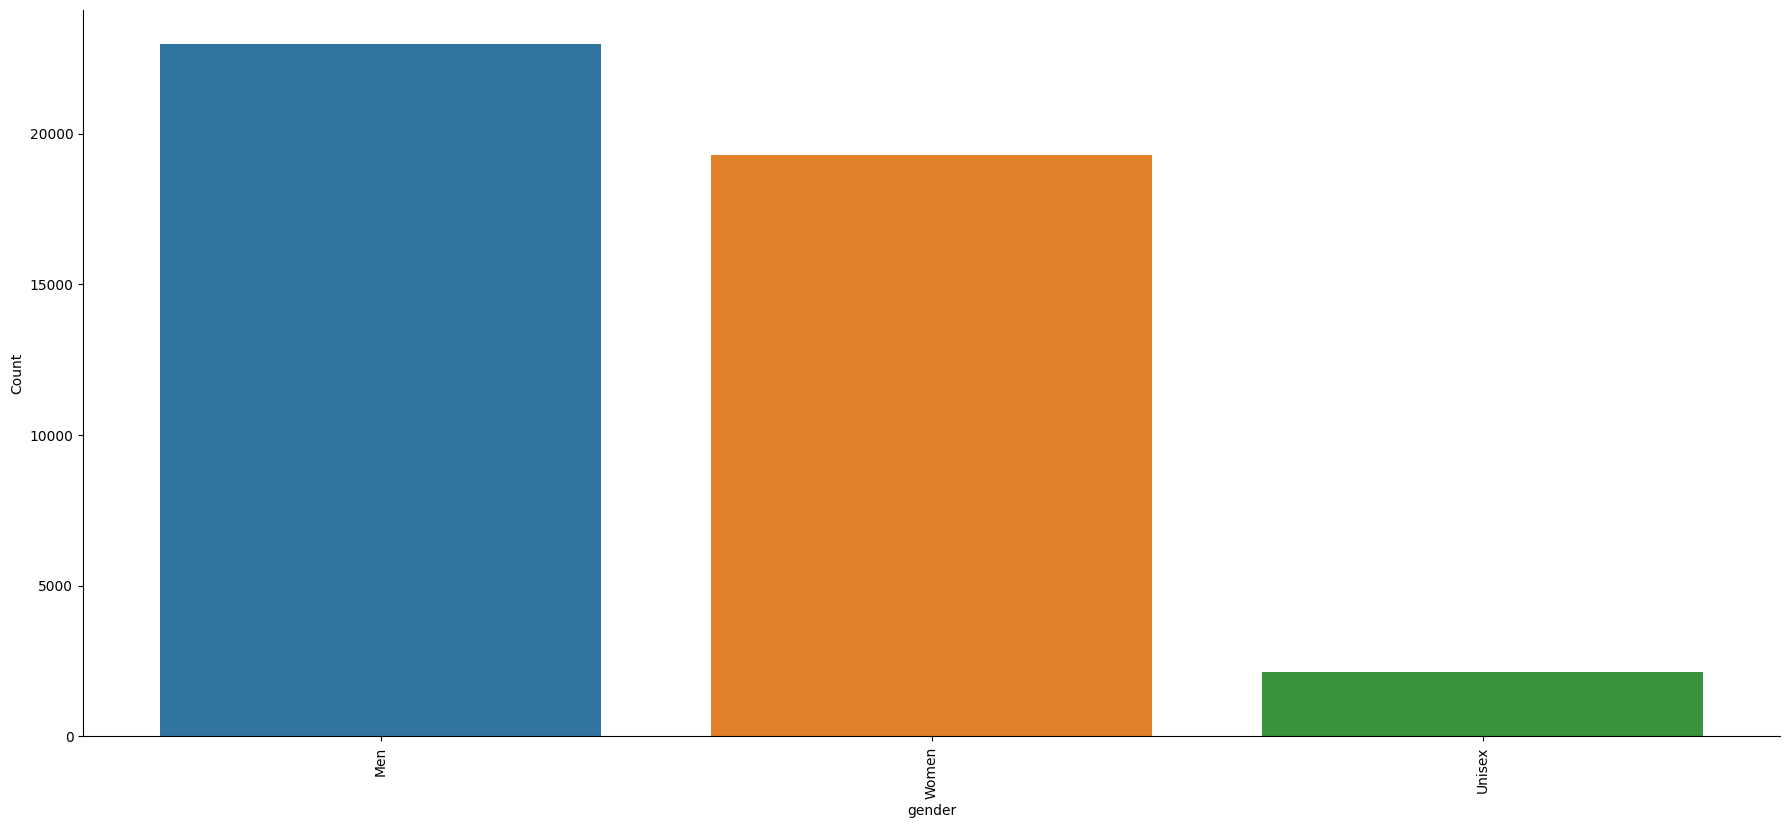

In [109]:
for i in train_df.columns:
    sorted_articles = train_df[i].value_counts().index.tolist()
    sns.catplot(x=i, kind='count', data=styles, height=8, aspect=18/8, order=sorted_articles) 
    plt.xlabel(i) 
    plt.ylabel("Count") 
    plt.xticks(rotation=90)
    plt.plot()

In [48]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = {}
for col in train_df_encoded.columns:
    classes = np.unique(train_df_encoded[col])
    weights = compute_class_weight('balanced', classes=classes, y=train_df_encoded[col])
    class_weights[col] = dict(zip(classes, weights))

print("Class Weights:", class_weights)

Class Weights: {'baseColour': {0: 0.3458962763398441, 1: 0.6427498659038083, 2: 0.9933407018513402, 3: 1.7570381231671555, 4: 1.9698082191780821, 5: 4.52188679245283, 6: 2.269507575757576, 7: 0.8998498122653317, 8: 0.7221574929690638, 9: 3.2068688670829615}, 'articleType': {0: 2.3198890036138358, 1: 2.0483760683760686, 2: 3.582004782781985, 3: 1.978045559590624, 4: 0.6008925885066694, 5: 3.610062261498293, 6: 3.3641212801796745, 7: 1.8837245860406624, 8: 2.679561717352415, 9: 0.9555313380468875, 10: 1.2982665222101841, 11: 2.7932400932400934, 12: 0.943791021265424, 13: 0.19424751983054878, 14: 2.8745402206940667, 15: 1.8786057692307692, 16: 0.5293468017434326, 17: 3.128176122520014, 18: 2.513916083916084, 19: 0.8456598447424135, 20: 1.5765722305060959, 21: 0.9792166049248202, 22: 3.215474060822898, 23: 0.24415572066993574, 24: 1.8003305288461537, 25: 0.6738079172289698}, 'season': {0: 0.9715945945945946, 1: 3.7493742177722154, 2: 0.5168353556846282, 3: 1.3000506292492406}, 'gender': {0